# We Rate Dogs - Wrangle and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">1. Introduction</a></li>
<li><a href="#gathering">2. Gathering data</a></li>
<li><a href="#assessing">3. Assessing data</a></li>   
<li><a href="#cleaning">4. Cleaning data</a></li>   
<li><a href="#storing">5. Storing, analyzing and visualizing data</a></li>
<li><a href="#resources">6. Resources</a></li>

</ul>

<a id='intro'></a>
## 1. Introduction

Real-world data rarely comes clean. Using Python and its libraries, you will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. You will document your wrangling efforts in a Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and/or SQL.


The dataset that will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.


<a id="gathering"></a>
## 2. Gathering data

In [1]:
# import related packages:
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
import os
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Read CSV file
1. The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

In [2]:
# read csv file:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')


In [3]:
twitter_archive.head(2)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [4]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Tweet image predictions
The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [5]:
# Download image predictions file programatically:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open ('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

 # Read the tsv file: 
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [6]:
image_predictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [7]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Twitter API and JSON
Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

In [8]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [9]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

2356

## Note to reviewer:  the code below was used as I am still awaiting access to a Twitter Developer account.
### Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
### Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [10]:
# converting the text file into a data list:
df_list = []

with open ('tweet_json.txt') as file:
    for line in file:
        df_list.append(json.loads(line))

In [11]:
print(df_list[0])

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'display_text_range': [0, 85], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}, 'extended_entities': {'media

In [12]:
# create a dataframe with tweet ID, retweet count, favourite count:
tweet_data = pd.DataFrame(df_list, columns = ['id', 'retweet_count', 'favorite_count'])

In [13]:
tweet_data.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [14]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


<a id="assessing"></a>
## 3. Assessing data

### twitter_archive
Will start with visually asessing twitter_archive table:

In [15]:
twitter_archive


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


Programmatic assessment of twitter_archive data:

In [16]:
twitter_archive.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
# check for unique values:
twitter_archive.nunique()


tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [18]:
# Review the ratings. While dogs are rated on a scale of 1-10, they are invariably given ratings in 
# excess of the maximum such as 13/10.  https://en.wikipedia.org/wiki/WeRateDogs
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [19]:
# review highest rating numerators for any errors:
twitter_archive.sort_values(by=['rating_numerator'], ascending = False)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Not familiar with this breed. N...,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133...,1,10,None,None,None,None,None
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [20]:
# extract ratings from the text string:
correct_rating = twitter_archive.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [21]:
# Review the denominator:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [22]:
# The majority of the denominator is 10.  Review for where the denominator is not 10: 
twitter_archive[twitter_archive['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [23]:
# Review top 20 names of dogs:
twitter_archive['name'].value_counts().nlargest(20)

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Lola        10
Tucker      10
Penny       10
Winston      9
Bo           9
the          8
Sadie        8
Bailey       7
Buddy        7
an           7
Daisy        7
Toby         7
Jax          6
Koda         6
Name: name, dtype: int64

In [24]:
# review dog names that are 'none'
twitter_archive[twitter_archive['name']=='None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,6,10,None,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Let's hope this flight isn't Malaysian (lol). ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100...,10,10,None,None,None,None,None
2344,666071193221509120,NaN,NaN,2015-11-16 01:52:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a northern speckled Rhododendron....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666071193...,9,10,None,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


**twitter_archive table:**

**Quality**
* There are 181 retweets
* tweet_id is of data type int, should be a string
* timestamp is an object, not in datetime format
* rating_numerator: it looks like the rating_numerators are within the text so should be extracted and replaced.
* rating_numerator: type should be float to account for decimals, not integer.
* rating_denominator: type should be float
* Names of dogs are not complete and there are a number of missing names and incorrect names (eg: a, the)

**Tidiness**
* Drop any columns that won't be used
* Split the datetime column into 2 separate columns with date and time. 
* doggo, floofer, pupper and puppo should be values rather than column headings.
* Combine with tweet_data table to see favourites and retweets

### image_predictions
Will start with visually asessing image_predictions table:

In [25]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


Programmatic assessment of image_predictions data:

In [26]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [28]:
image_predictions.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [29]:
# it looks like there are duplicated jpg_url from the .info above:
sum(image_predictions.jpg_url.duplicated())

66

In [30]:
# review the predictions:
image_predictions['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
fountain                1
tiger_shark             1
African_crocodile       1
envelope                1
mortarboard             1
Name: p1, Length: 378, dtype: int64

In [31]:
# manually check some of the jpg_url for where p1 = 'seat_belt'
image_predictions[image_predictions['p1'] == 'seat_belt']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
108,667878741721415682,https://pbs.twimg.com/media/CUTILFiWcAE8Rle.jpg,1,seat_belt,0.200373,False,miniature_pinscher,0.106003,True,schipperke,0.104733,True
198,669625907762618368,https://pbs.twimg.com/media/CUr9NjgU8AEpf5w.jpg,1,seat_belt,0.874502,False,golden_retriever,0.055408,True,Labrador_retriever,0.026854,True
235,670427002554466305,https://pbs.twimg.com/media/CU3VzVwWwAAAsst.jpg,1,seat_belt,0.952258,False,toy_terrier,0.038872,True,beagle,0.003226,True
522,676582956622721024,https://pbs.twimg.com/media/CWO0m8tUwAAB901.jpg,1,seat_belt,0.790028,False,Boston_bull,0.196307,True,French_bulldog,0.012429,True
551,677557565589463040,https://pbs.twimg.com/media/CWcrAVQWEAA6QMp.jpg,1,seat_belt,0.277257,False,Shih-Tzu,0.249017,True,Pekinese,0.209213,True
577,678740035362037760,https://pbs.twimg.com/media/CWtede2WIAAF_AJ.jpg,1,seat_belt,0.787164,False,sunglasses,0.045739,False,beagle,0.022525,True
642,681339448655802368,https://pbs.twimg.com/media/CXSanNkWkAAqR9M.jpg,1,seat_belt,0.532441,False,Labrador_retriever,0.094615,True,kuvasz,0.089863,True
657,682303737705140231,https://pbs.twimg.com/media/CXgHoLnWAAA8i52.jpg,1,seat_belt,0.997659,False,Lakeland_terrier,0.001731,True,Airedale,0.000204,True
740,687312378585812992,https://pbs.twimg.com/media/CYnS9VWW8AAeR8m.jpg,1,seat_belt,0.703561,False,Great_Dane,0.139909,True,Weimaraner,0.021112,True


**image_predictions table:**

**Quality**
* tweet_id is of data type int, should be string.
* Remove 66 duplicated jpg_url rows.

**Tidiness**
* Drop any columns that won't be used.
* Inconsistent use of lower case and upper case letters for the names
* Merge with twitter_archive table


### tweet_data
Will start with visually asessing tweet_data table:

In [32]:
tweet_data

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [33]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [34]:
tweet_data.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


**tweet_data table:**

**Quality**
* rename id column to tweet_id
* tweet_id is of data type int, should be string.

**Tidiness**
* Merge tweet_data table with twitter_archives table

<a id="cleaning"></a>
## 4. Cleaning data

In [35]:
# make clean copies of the tables:
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_data_clean = tweet_data.copy()

### twitter_archive_clean


#### Define:
* Delete tweets that have been retweeted. 

#### Code:

In [36]:
twitter_archive_clean = twitter_archive_clean[np.isnan(twitter_archive_clean['retweeted_status_id'])]

#### Test:

In [37]:
twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Define:
Drop columns we don't need: 
* in_reply_to_status_id
* in_reply_to_user_id
* source
* retweeted_status_id
* retweeted_status_user_id
* retweeted_status_timestamp
* expanded_urls

#### Code:

In [38]:
twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id', 
                                                    'in_reply_to_user_id', 
                                                    'source', 
                                                    'retweeted_status_id',
                                                    'retweeted_status_user_id', 
                                                    'retweeted_status_timestamp', 
                                                    'expanded_urls'], axis = 1)

#### Test:

In [39]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   text                2175 non-null   object
 3   rating_numerator    2175 non-null   int64 
 4   rating_denominator  2175 non-null   int64 
 5   name                2175 non-null   object
 6   doggo               2175 non-null   object
 7   floofer             2175 non-null   object
 8   pupper              2175 non-null   object
 9   puppo               2175 non-null   object
dtypes: int64(3), object(7)
memory usage: 186.9+ KB


#### Define:
* Bring dog types (doggo, floofer, pupper, puppo) into one column

#### Code:

In [40]:
# convert nones and NaN to empty string for all columns:
twitter_archive_clean['doggo'].replace('None', '', inplace=True)
twitter_archive_clean['doggo'].replace(np.NaN, '', inplace=True)
twitter_archive_clean['floofer'].replace('None', '', inplace=True)
twitter_archive_clean['floofer'].replace(np.NaN, '', inplace=True)
twitter_archive_clean['pupper'].replace('None', '', inplace=True)
twitter_archive_clean['pupper'].replace(np.NaN, '', inplace=True)
twitter_archive_clean['puppo'].replace('None', '', inplace=True)
twitter_archive_clean['puppo'].replace(np.NaN, '', inplace=True)


In [41]:
# combine the columns into a column called dog_stages: 
twitter_archive_clean['dog_stages'] = twitter_archive_clean.text.str.extract('(doggo|floofer|pupper|puppo)', expand = True)

In [42]:
# some dogs have multiple stages:
twitter_archive_clean['dog_stages'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo
twitter_archive_clean.loc[twitter_archive_clean.dog_stages == 'doggopupper', 'dog_stages'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stages == 'doggopuppo', 'dog_stages'] = 'doggo, puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stages == 'doggofloofer', 'dog_stages'] = 'doggo, floofer'


In [43]:
# delete the doggo, floofer, pupper and puppo columns:
twitter_archive_clean.drop(['doggo', 'floofer', 'puppo', 'pupper'], axis = 1, inplace = True)

#### Test:

In [44]:
twitter_archive_clean['dog_stages'].value_counts()

                  1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: dog_stages, dtype: int64

In [45]:
twitter_archive_clean.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stages
739,780601303617732608,2016-09-27 02:53:48 +0000,Meet Hercules. He can have whatever he wants f...,12,10,Hercules,
2204,668636665813057536,2015-11-23 03:46:18 +0000,This is an Irish Rigatoni terrier named Berta....,10,10,an,
848,766069199026450432,2016-08-18 00:28:24 +0000,This is Juno. She can see your future. 12/10 h...,12,10,Juno,
1564,688116655151435777,2016-01-15 21:52:49 +0000,Please send dogs. I'm tired of seeing other st...,10,10,None,
2305,666837028449972224,2015-11-18 04:35:11 +0000,My goodness. Very rare dog here. Large. Tail d...,3,10,None,


#### Define:
* Replace the rating_numerator and rating_denominator with the values from the text column. 

#### Code:

In [46]:
correct_rating = twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
twitter_archive_clean[['rating_numerator', 'rating_denominator']] = correct_rating

#### Test:

In [47]:
twitter_archive_clean['rating_numerator'].value_counts()

12       500
10       442
11       426
13       307
9        156
8         98
7         53
14        43
5         34
6         32
3         19
4         17
2          9
1          8
420        2
0          2
20         1
007        1
121        1
13.5       1
60         1
182        1
1776       1
99         1
204        1
9.5        1
50         1
15         1
24         1
17         1
666        1
960        1
84         1
11.27      1
9.75       1
45         1
44         1
143        1
88         1
80         1
11.26      1
144        1
165        1
Name: rating_numerator, dtype: int64

In [48]:
twitter_archive_clean.query('rating_numerator =="11.26"') 

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stages
1712,680494726643068929,2015-12-25 21:06:00 +0000,Here we have uncovered an entire battalion of ...,11.26,10,None,


In [49]:
# on visually assessing, found that index 1202 was incorrect, the rating numerator should be 11 and the
# rating denominator should be 10:
twitter_archive_clean.query('rating_numerator =="50"') ## the below should be 11/10 

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stages
1202,716439118184652801,2016-04-03 01:36:11 +0000,This is Bluebert. He just saw that both #Final...,50,50,Bluebert,


In [50]:
# code to change the rating_numerator and rating_denominator:
twitter_archive_clean.loc[twitter_archive_clean.index == 1202, 'rating_numerator'] = 11
twitter_archive_clean.loc[twitter_archive_clean.index == 1202, 'rating_denominator'] = 10


In [51]:
# test to see the change is successful:
twitter_archive_clean.loc[twitter_archive_clean.index == 1202]


,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stages
1202,716439118184652801,2016-04-03 01:36:11 +0000,This is Bluebert. He just saw that both #Final...,11,10,Bluebert,


In [52]:
# Another visual assessment found that index 2335 should be 9/10 rather than 1/2:
twitter_archive_clean.query('rating_denominator == "2"') ## the below should be 9/10

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stages
2335,666287406224695296,2015-11-16 16:11:11 +0000,This is an Albanian 3 1/2 legged Episcopalian...,1,2,an,


In [53]:
# code to change the rating_numerator and rating_denominator:
twitter_archive_clean.loc[twitter_archive_clean.index == 2335, 'rating_numerator'] = 9
twitter_archive_clean.loc[twitter_archive_clean.index == 2335, 'rating_denominator'] = 10

In [54]:
# test to see the change is successful:
twitter_archive_clean.loc[twitter_archive_clean.index == 2335]


,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_stages
2335,666287406224695296,2015-11-16 16:11:11 +0000,This is an Albanian 3 1/2 legged Episcopalian...,9,10,an,


#### Define:
* Change the data type of tweet_id to string
* Change rating_numerator to float
* Change rating_denominator to float

#### Code:

In [55]:
# tweet_id to string:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)

In [56]:
# rating numerator to float:
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(float)
#rating denominator to float:
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype(float)


#### Test:

In [57]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2175 non-null   object 
 1   timestamp           2175 non-null   object 
 2   text                2175 non-null   object 
 3   rating_numerator    2175 non-null   float64
 4   rating_denominator  2175 non-null   float64
 5   name                2175 non-null   object 
 6   dog_stages          2175 non-null   object 
dtypes: float64(2), object(5)
memory usage: 135.9+ KB


#### Define:
* Convert timestamp column to datetime format
* Split timestamp column into two separate columns - date and time
* Drop timestamp column

In [58]:
# convert timestamp column to datetime format:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'] )

In [59]:
# split out date and time into two separate columns:
twitter_archive_clean['date'] = twitter_archive_clean['timestamp'].dt.date
twitter_archive_clean['time'] = twitter_archive_clean['timestamp'].dt.time


In [60]:
# drop timestamp column:
twitter_archive_clean.drop(['timestamp'], axis = 1, inplace = True)

#### Test:

In [61]:
twitter_archive_clean.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,dog_stages,date,time
2247,667873844930215936,Neat dog. Lots of spikes. Always in push-up po...,10.0,10.0,None,,2015-11-21,01:15:07
521,809920764300447744,"Please only send in dogs. We only rate dogs, n...",10.0,10.0,None,,2016-12-17,00:38:52
468,817056546584727552,This is Chloe. She fell asleep at the wheel. A...,11.0,10.0,Chloe,,2017-01-05,17:13:55
393,825876512159186944,This is Mo. No one will push him around in the...,11.0,10.0,Mo,,2017-01-30,01:21:19
65,879492040517615616,This is Bailey. He thinks you should measure e...,12.0,10.0,Bailey,,2017-06-27,00:10:17


### image_predictions_clean


#### Define:
* Drop duplicated jpg_url

#### Code:

In [62]:
image_predictions_clean= image_predictions_clean.drop_duplicates(subset = 'jpg_url', keep = 'last')

#### Test:

In [63]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2009 non-null   int64  
 1   jpg_url   2009 non-null   object 
 2   img_num   2009 non-null   int64  
 3   p1        2009 non-null   object 
 4   p1_conf   2009 non-null   float64
 5   p1_dog    2009 non-null   bool   
 6   p2        2009 non-null   object 
 7   p2_conf   2009 non-null   float64
 8   p2_dog    2009 non-null   bool   
 9   p3        2009 non-null   object 
 10  p3_conf   2009 non-null   float64
 11  p3_dog    2009 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 162.8+ KB


In [64]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Define:
Drop columns that won't be used in analysis:
* img_num
* p2
* p2_conf
* p2_dog
* p3
* p3_conf
* p3_dog

#### Code:

In [65]:
image_predictions_clean = image_predictions_clean.drop(['img_num', 
                                                        'p2', 
                                                        'p2_conf', 
                                                        'p2_dog', 
                                                        'p3', 
                                                        'p3_conf', 
                                                        'p3_dog'], axis = 1)

#### Test:

In [66]:
image_predictions_clean.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True


#### Define:
* change tweet_id from int to string

#### Code:

In [67]:
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)

#### Test:

In [68]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2009 non-null   object 
 1   jpg_url   2009 non-null   object 
 2   p1        2009 non-null   object 
 3   p1_conf   2009 non-null   float64
 4   p1_dog    2009 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 80.4+ KB


#### Define:
* Capitalise the first letter of the prediction (p1) column

#### Code:

In [69]:
image_predictions_clean['p1'] = image_predictions_clean['p1'].str.capitalize()

#### Define:
* Merge image_predictions_clean table with twitter_archive_clean table. 

In [70]:
twitter_archive_clean = pd.merge(twitter_archive_clean, image_predictions_clean, on = 'tweet_id', how = 'inner')

#### Test:

In [71]:
twitter_archive_clean.head(2)

,tweet_id,text,rating_numerator,rating_denominator,name,dog_stages,date,time,jpg_url,p1,p1_conf,p1_dog
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,,2017-08-01,16:23:56,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Orange,0.097049,False
1,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,,2017-08-01,00:17:27,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True


In [72]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 1927
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1928 non-null   object 
 1   text                1928 non-null   object 
 2   rating_numerator    1928 non-null   float64
 3   rating_denominator  1928 non-null   float64
 4   name                1928 non-null   object 
 5   dog_stages          1928 non-null   object 
 6   date                1928 non-null   object 
 7   time                1928 non-null   object 
 8   jpg_url             1928 non-null   object 
 9   p1                  1928 non-null   object 
 10  p1_conf             1928 non-null   float64
 11  p1_dog              1928 non-null   bool   
dtypes: bool(1), float64(3), object(8)
memory usage: 182.6+ KB


### tweet_data_clean


#### Define:
* Rename id column to tweet_id

#### Code: 

In [73]:
# rename id to tweet_id:
tweet_data_clean = tweet_data_clean.rename(columns = {'id':'tweet_id'})

#### Test:

In [74]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


#### Define:
* Change tweet_id from int to string

#### Code:

In [75]:
tweet_data_clean['tweet_id'] = tweet_data_clean['tweet_id'].astype(str)

#### Test:

In [76]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


#### Define:
* Merge tweet_data_clean table with twitter_archive_clean table

#### Code:

In [77]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_data_clean, on = 'tweet_id', how = 'left')

#### Test:

In [78]:
twitter_archive_clean.head(2)

,tweet_id,text,rating_numerator,rating_denominator,name,dog_stages,date,time,jpg_url,p1,p1_conf,p1_dog,retweet_count,favorite_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,,2017-08-01,16:23:56,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Orange,0.097049,False,8853,39467
1,892177421306343426,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,,2017-08-01,00:17:27,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,6514,33819


In [79]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 1927
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1928 non-null   object 
 1   text                1928 non-null   object 
 2   rating_numerator    1928 non-null   float64
 3   rating_denominator  1928 non-null   float64
 4   name                1928 non-null   object 
 5   dog_stages          1928 non-null   object 
 6   date                1928 non-null   object 
 7   time                1928 non-null   object 
 8   jpg_url             1928 non-null   object 
 9   p1                  1928 non-null   object 
 10  p1_conf             1928 non-null   float64
 11  p1_dog              1928 non-null   bool   
 12  retweet_count       1928 non-null   int64  
 13  favorite_count      1928 non-null   int64  
dtypes: bool(1), float64(3), int64(2), object(8)
memory usage: 212.8+ KB


<a id="storing"></a>
## 5. Storing, analyzing and visualizing data

Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv

In [80]:
# Store the clean dataframes ina csv file with the main one named 'twtter_archive_master.csv':

twitter_archive_clean.to_csv('twitter_archive_master.csv', index = False)
image_predictions_clean.to_csv('image_predictions_clean.csv', index = False)
tweet_data_clean.to_csv('tweet_data_clean.csv', index = False)

In [81]:
df_twitter = pd.read_csv('twitter_archive_master.csv')

In [82]:
df_twitter.sample()

,tweet_id,text,rating_numerator,rating_denominator,name,dog_stages,date,time,jpg_url,p1,p1_conf,p1_dog,retweet_count,favorite_count
1014,702932127499816960,This is Chip. He's an Upper West Nile Pantaloo...,6.0,10.0,Chip,NaN,2016-02-25,19:04:13,https://pbs.twimg.com/media/CcFRCfRW4AA5a72.jpg,Wallaby,0.41071,False,811,2825


#### 1. What is the most popular dog breed:

In [83]:
# retrieve top 10 dog breed predictions:
pop_dogs = df_twitter['p1'].value_counts().nlargest(10)
pop_dogs


Golden_retriever      128
Labrador_retriever     90
Pembroke               87
Chihuahua              75
Pug                    52
Pomeranian             38
Chow                   38
Samoyed                37
Toy_poodle             37
Malamute               28
Name: p1, dtype: int64

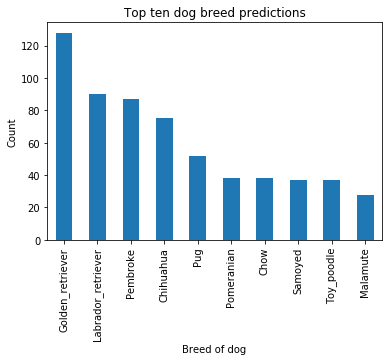

In [84]:
# plot on bar graph
pop_dogs.plot(kind = 'bar')
plt.title('Top ten dog breed predictions')
plt.xlabel('Breed of dog')
plt.ylabel('Count')
plt.savefig('breeds.jpeg', dpi='figure', bbox_inches = 'tight', pad_inches = 0.1);

#### 2. What are the frequencies of photos that are not dogs?

In [85]:
# filter by p1_dog column == False.  This means that the prediction is not a dog. 
not_dogs = df_twitter[df_twitter['p1_dog'] == False]

In [86]:
# compute the frequency of predictions that are not dogs, filter to top 20. 
not_dogs_top_ten = not_dogs['p1'].value_counts(sort = True, normalize = True).nlargest(10)
not_dogs_top_ten

Seat_belt      0.039761
Teddy          0.035785
Web_site       0.029821
Dingo          0.017893
Tennis_ball    0.017893
Bath_towel     0.013917
Doormat        0.013917
Hamster        0.013917
Swing          0.013917
Siamese_cat    0.013917
Name: p1, dtype: float64

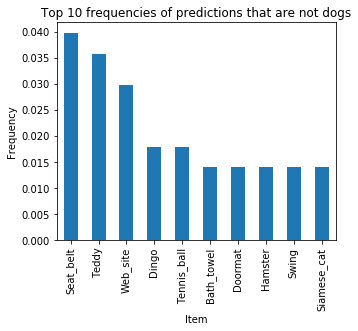

In [87]:
# plot frequency on bar graph:
not_dogs_top_ten.plot(kind = 'bar', figsize = (5,4))
plt.title('Top 10 frequencies of predictions that are not dogs')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.savefig('not_dogs.jpeg', dpi='figure', bbox_inches = 'tight', pad_inches = 0.1);

#### 3. What is the relationship between retweet acount vs favourite counts

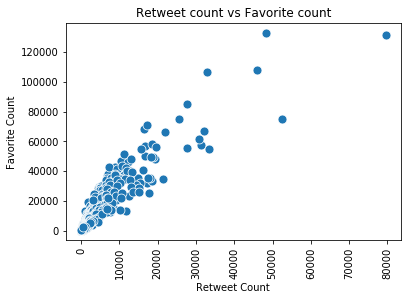

In [88]:
#plot on graph
sns.scatterplot(data = df_twitter, x="retweet_count", y = "favorite_count", s=80)
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.title('Retweet count vs Favorite count')
plt.xticks(rotation = 90)
plt.savefig('retweets.jpeg', dpi='figure', bbox_inches = 'tight', pad_inches = 0.1);

#### 4. What is the number of tweets over the duration of the dataset?

In [89]:
# filter by date and number of tweets on each day. 
tweet_dates = df_twitter['tweet_id'].groupby(df_twitter['date']).count()
tweet_dates.sort_values()

date
2016-09-19     1
2017-01-28     1
2017-01-26     1
2016-05-08     1
2016-05-09     1
              ..
2015-12-01    23
2015-11-19    23
2015-11-28    25
2015-11-16    25
2015-11-29    26
Name: tweet_id, Length: 584, dtype: int64

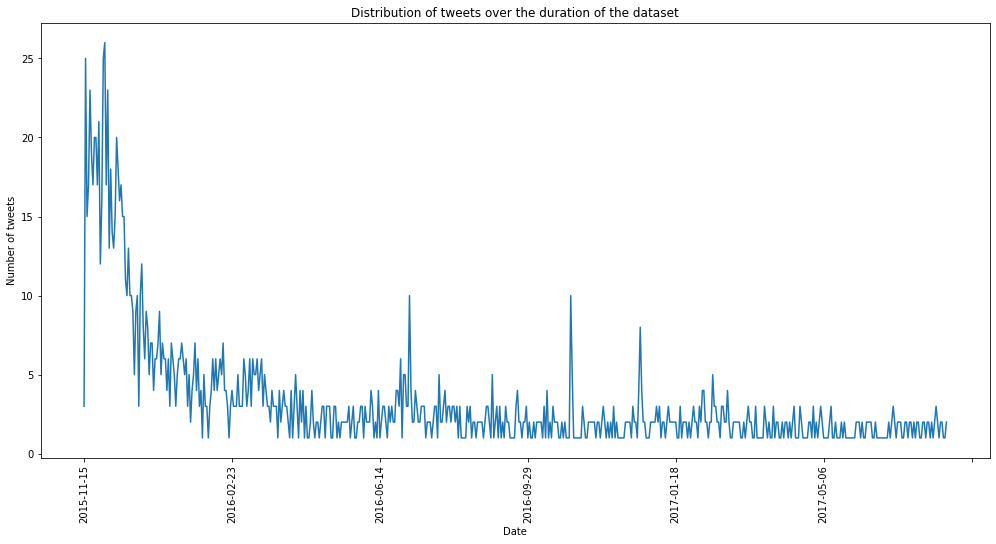

In [90]:
# plot on a graph:
tweet_dates.plot(kind = 'line', figsize = (17, 8))
plt.xticks(rotation = 90)
plt.title('Distribution of tweets over the duration of the dataset')
plt.xlabel('Date')
plt.ylabel('Number of tweets')
plt.savefig('duration.jpeg', dpi='figure', bbox_inches = 'tight', pad_inches = 0.1);

In [91]:
# get max and min dates to find the duration of the dataset:
df_twitter['date'].max(), df_twitter['date'].min()

('2017-08-01', '2015-11-15')

<a id="resources"></a>
## 6. Resources

* https://knowledge.udacity.com/questions/33009
* https://knowledge.udacity.com/questions/124876
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
* https://stackoverflow.com/questions/35364601/group-by-and-find-top-n-value-counts-pandas
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html